In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
# silhouette_score

<Axes: xlabel='Segmentation'>

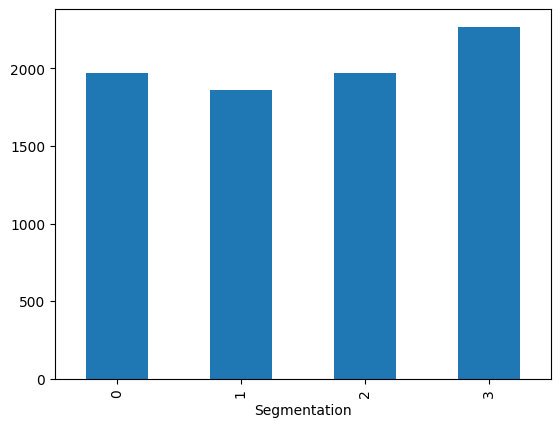

In [3]:

# --- Load and Prepare Data ---
df = pd.read_csv("./../Processed_datasets/utomobile_customer_segmentation/train_processed_data.csv")  # replace with your actual file path
df.Segmentation.value_counts().sort_index().plot(kind='bar')


In [4]:
X= df.drop(columns=['Segmentation','Var_1'])


In [5]:
X=X.values

In [6]:
# --- Parameters ---
K = 4  # Number of clusters
max_iter = 100
initial_temp = 100
cooling_rate = 0.95

# --- Initialize cluster centers randomly ---
def initialize_centroids(X, k):
    indices = np.random.choice(len(X), k, replace=False)
    return X[indices]

# --- Assign points to closest cluster ---
def assign_clusters(X, centroids):
    labels, _ = pairwise_distances_argmin_min(X, centroids)
    return labels

# --- Calculate total within-cluster distance (cost) ---
def calculate_cost(X, labels, centroids):
    return sum(np.linalg.norm(X[i] - centroids[labels[i]])**2 for i in range(len(X)))

# --- Perturb centroids slightly ---
def perturb_centroids(centroids, scale=0.1):
    noise = np.random.normal(0, scale, centroids.shape)
    return centroids + noise

# --- Simulated Annealing Clustering ---
def simulated_annealing(X, k, max_iter, initial_temp, cooling_rate):
    current_centroids = initialize_centroids(X, k)
    current_labels = assign_clusters(X, current_centroids)
    current_cost = calculate_cost(X, current_labels, current_centroids)

    best_centroids = current_centroids.copy()
    best_labels = current_labels.copy()  # ✅ Track labels for best solution
    best_cost = current_cost

    temp = initial_temp

    for i in range(max_iter):
        new_centroids = perturb_centroids(current_centroids)
        new_labels = assign_clusters(X, new_centroids)
        new_cost = calculate_cost(X, new_labels, new_centroids)

        # Decide whether to accept the new solution
        if new_cost < current_cost or np.random.rand() < np.exp((current_cost - new_cost) / temp):
            current_centroids = new_centroids
            current_cost = new_cost
            current_labels = new_labels

            if new_cost < best_cost:
                best_centroids = new_centroids
                best_cost = new_cost
                best_labels = new_labels  # ✅ Save best labels

        temp *= cooling_rate

    return best_labels, best_centroids, best_cost


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

results = {
    "k": [],
    "best_labels": [],
    "best_centroids": [],
    "best_cost": [],
    "silhouette": [],
    "ch_score": [],
    "inertia": []
}

ks = list(range(3, 11))
seeds = list(range(1, 31))

for k in ks:
    print(f"Running for k = {k}")
    for run in range(30):
        print(f"Run {run}")

        # Assuming simulated_annealing returns labels, centroids, cost
        best_labels, best_centroids, best_cost = simulated_annealing(X, k, max_iter, initial_temp, cooling_rate)

        # Evaluate clustering
        silhouette = silhouette_score(X, best_labels)
        ch_score = calinski_harabasz_score(X, best_labels)

        # If inertia is required, you may need to compute it manually:
        inertia = 0
        for i in range(k):
            cluster_points = X[best_labels == i]
            centroid = best_centroids[i]
            inertia += ((cluster_points - centroid) ** 2).sum()

        # Append results
        results["k"].append(k)
        results["best_labels"].append(best_labels)
        results["best_centroids"].append(best_centroids)
        results["best_cost"].append(best_cost)
        results["silhouette"].append(silhouette)
        results["ch_score"].append(ch_score)
        results["inertia"].append(inertia)


In [35]:
pd.DataFrame(results).to_csv("./SA_results.csv",index=False)

In [29]:
results_df.drop(columns=['best_labels','best_centroids'],inplace=True)
run_df=results_df

In [30]:
avarage_df_runs= run_df.groupby("k").mean()

In [31]:
avarage_df_runs

,best_cost,silhouette,ch_score,inertia
k,,,,
3,50365.953056,0.248818,3992.923698,50365.953056
4,45845.256994,0.201994,3270.007056,45845.256994
5,42332.430851,0.191889,2837.812091,42332.430851
6,39938.121797,0.173980,2600.056291,39938.121797
7,38945.958535,0.171021,2410.276529,38945.958535
8,36630.979550,0.169962,2212.149404,36630.979550
9,33716.515795,0.165688,2163.320547,33716.515795
10,33226.593508,0.165119,2053.206228,33226.593508


In [32]:
scaler = MinMaxScaler()
run_df['neg_inertia'] = -run_df['inertia']
scaled_metrics = scaler.fit_transform(run_df[['silhouette', 'ch_score', 'neg_inertia']])
scaled_df = pd.DataFrame(scaled_metrics, columns=['scaled_silhouette', 'scaled_ch', 'scaled_neg_inertia'], index=run_df.index)

run_df['composite_score'] = (
    0.2 * scaled_df['scaled_silhouette'] +
    0.4 * scaled_df['scaled_ch'] +
    0.4 * scaled_df['scaled_neg_inertia']
)

# --- Sort and display ---
ranked = run_df.sort_values(by='composite_score', ascending=False)

print(ranked[['silhouette', 'ch_score', 'inertia', 'composite_score']])

     silhouette     ch_score       inertia  composite_score
4      0.333250  4988.704341  43180.354905         0.876591
3      0.327005  5015.293925  46505.830453         0.849141
6      0.328790  4368.408779  44109.581464         0.799762
17     0.244449  4766.867096  44693.772637         0.781522
19     0.234261  4584.350765  43914.064318         0.761255
..          ...          ...           ...              ...
179    0.139875  1494.511675  42511.923046         0.377674
37     0.148180  2601.994370  58989.205814         0.372581
178    0.041964  1537.813887  43357.140276         0.310207
10     0.164512  2462.294440  76787.813104         0.228676
137    0.061840  1286.790063  79412.277299         0.013291

[240 rows x 4 columns]


In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)

# for result in results:
#     X_pca = pca.fit_transform(X)
#     centroids_pca = pca.transform(best_centroids)
#     print(f"Seed: {result['seed']}, Cost: {result['cost']}")
#     print("Centroids (PCA):\n", centroids_pca)
#     print("Labels:\n", result['labels'])



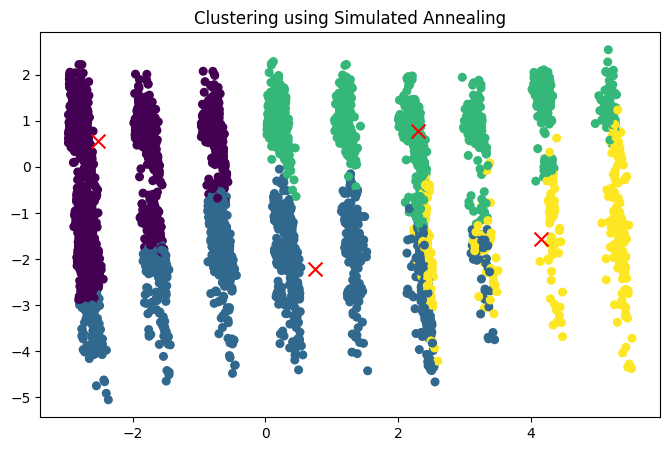

In [ ]:
# plt.figure(figsize=(8, 5))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis', s=30)
# plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=100, marker='x')
# plt.title("Clustering using Simulated Annealing")
# plt.show()

<Axes: >

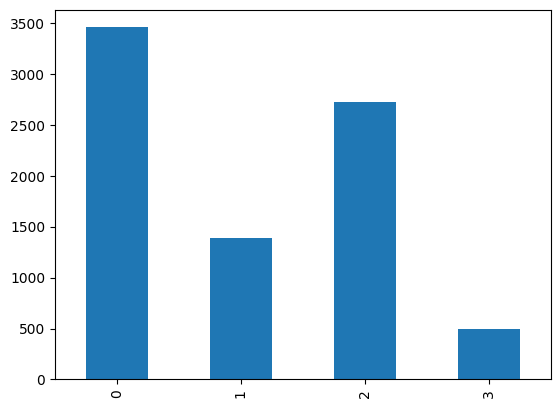

In [ ]:
# pd.Series(best_labels).value_counts().sort_index().plot(kind='bar')

In [ ]:
# df

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
0,-1.284623,-0.499892,0.757947,1,0,0,5,2,3,3
1,-0.327151,0.537954,0.096095,0,1,1,2,0,3,0
2,1.408268,-0.499892,-1.227610,0,1,1,2,2,5,1
3,1.408268,-0.805141,-0.565758,1,1,1,7,1,5,1
4,-0.207467,1.453700,2.081652,0,1,1,3,1,5,0
...,...,...,...,...,...,...,...,...,...,...
8063,-1.284623,-0.805141,2.743505,1,0,0,0,2,0,3
8064,-0.506677,0.110605,0.757947,1,0,0,4,2,3,3
8065,-0.626361,-0.499892,-1.227610,0,0,1,5,2,5,3
8066,-0.985413,-0.499892,0.757947,0,0,1,5,2,5,1


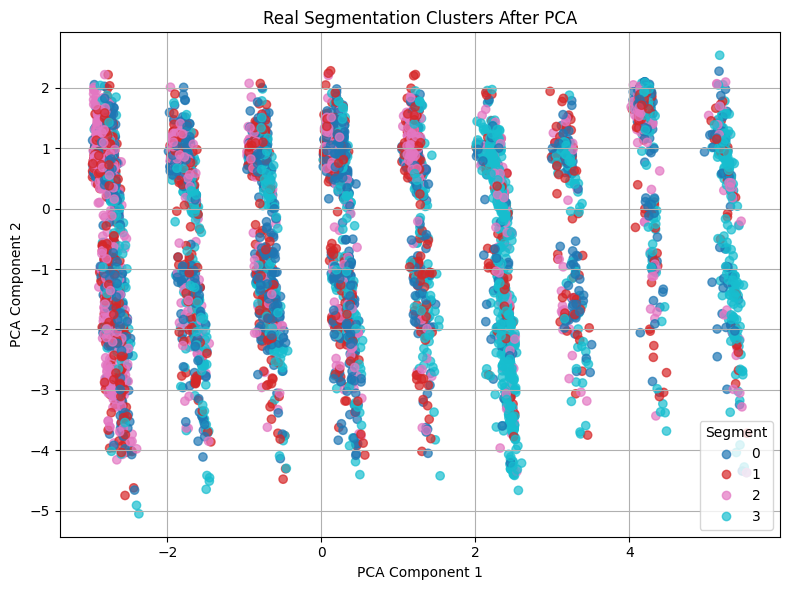

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # --- Load and Prepare Data ---
# df = pd.read_csv("./../Processed_datasets/utomobile_customer_segmentation/train_processed_data.csv")

# # Drop 'Segmentation' from training features, but keep it for plotting
# X = df.drop(columns=['Segmentation'])
# y_true = df['Segmentation']  # Actual labels for visualization

# # --- PCA Transformation ---
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)  # Assuming same transformation used in training

# # --- Plot Real Clusters (Ground Truth) ---
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='tab10', alpha=0.7)
# plt.title("Real Segmentation Clusters After PCA")
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
# plt.legend(*scatter.legend_elements(), title="Segment")
# plt.grid(True)
# plt.tight_layout()
# plt.show()
